In [43]:
from dotenv import load_dotenv
load_dotenv(".env");

import shutil
from pathlib import Path
from click import progressbar
from numpy import isin, stack, newaxis, uint8
from torch import tensor, float32, int64
from pandas import DataFrame, concat
from imageio.v3 import imread, imwrite
from torchvision.transforms.v2 import(
    Compose, ToImage, ToDtype, Identity)
from torchvision.datasets.utils import download_url
from tqdm.notebook import tqdm
import zipfile

from etl.extract import extract_multivolume_archive 
from datasets.inria import InriaBase, InriaStreaming

from typing import Any, Literal, Optional
from numpy.typing import NDArray
from torch import Tensor
from torchvision.transforms.v2 import Transform

DATA = Path.home() / "datasets" / "urban-footprint"

_kwargs = {
            "val_split": .2,
            "test_split": .2,
            "random_seed" : 42,
            "tile_size" : (512, 512),
            "tile_stride" : (512, 512) 
        }

DATA = Path.home() / "datasets" / "urban-footprint" 
STREAMING = Path.home() / "shards" / "urban-footprint"
URL = "s3://segmentation/shards/urban-footprint"

class HDF5Segmentation:
    DEFAULT_IMAGE_TRANSFORM = Compose([
                ToImage(),
                ToDtype(float32, scale=True),
            ])
        
    DEFAULT_TARGET_TRANSFORM = Compose([
        ToImage(),
        ToDtype(int64, scale=False),
    ])

    DEFAULT_COMMON_TRANSFORM = Identity()

    def __init__(
            self,
            hdf5_path: Path,
            df: DataFrame,
            tiled: bool,
            split: Literal["train", "val", "test", "unsup"] = "train",
            image_transform: Optional[Transform] = None,
            target_transform: Optional[Transform] = None,
            common_transform: Optional[Transform] = None,
            **kwargs
        ) -> None:

        assert hdf5_path.is_file(), "provide .hdf5 dataset path"
        assert isinstance(df, DataFrame), "not a dataframe"
        assert split in ("train", "val", "trainval", "test", "unsup"), "invalid split"

        self.hdf5_path = hdf5_path
        self.image_transform = image_transform or self.DEFAULT_IMAGE_TRANSFORM
        self.target_transform = target_transform or self.DEFAULT_TARGET_TRANSFORM 
        self.common_transform = common_transform or self.DEFAULT_COMMON_TRANSFORM

        with h5py.File(self.hdf5_path, "r") as f:
            self.dataset_shape = f["images"].shape

        self.df = (
            df
            .pipe(self.__subset_df, split)
        ) 

        if tiled:
            cols = set(df.columns)
            required_cols = {"name", "scene_idx", "height_begin", "height_end", "width_begin", "width_end"}
            assert required_cols.issubset(cols), f"{required_cols.difference(cols)} are missing"
            self.__getitem__ = self.__get_tile
        else:
            assert "name" in df.columns, f"name is missing"
            self.__getitem__ = self.__get_scene

    def __len__(self):
        return len(self.df)

    def __get_scene(self, idx: int):
        with h5py.File(self.hdf5_path, "r") as f:
            image, mask = f["images"][idx], f["masks"][idx]
        return *self.common_transform([self.image_transform(image), self.target_transform(mask)]), str(self.df.iloc[idx]["name"])

    def __get_tile(self, idx: int):
        tile = self.df.iloc[idx]
        with h5py.File(self.hdf5_path, "r") as f:
            if tile["height_end"] >= self.dataset_shape[1] or tile["width_end"] >= self.dataset_shape[2]:
                image = self.__get_padded_image(f["images"], tile["scene_idx"], tile["height_begin"], tile["height_end"], tile["width_begin"], tile["width_end"])
                mask = self.__get_padded_image(f["masks"], tile["scene_idx"], tile["height_begin"], tile["height_end"], tile["width_begin"], tile["width_end"])
            else:
                image = f["images"][idx, tile["height_begin"]:tile["height_end"], tile["width_begin"]:tile["width_end"]]
                mask = f["images"][idx, tile["height_begin"]:tile["height_end"], tile["width_begin"]:tile["width_end"]]
        return *self.common_transform([self.image_transform(image), self.target_transform(mask)]), str(tile["name"])

    def __get_padded_image(self, dataset: Any, idx: int, height_begin: int, height_end: int, width_begin: int, width_end: int) -> NDArray:
        dataset_max_height = dataset.shape[1]
        dataset_max_width = dataset.shape[2]
        image = pad(
            dataset[idx, height_begin: dataset_max_height, width_begin: dataset_max_width],
            ((0, height_end - dataset_max_height), (0, width_end - dataset_max_width), (0, 0)),
            "constant",
            constant_values = 0
        )
        return image

    def __subset_df(self, df: DataFrame, split: str) -> DataFrame:
        if split == "trainval":
            return df[(df.split == "train") | (df.split == "val")]
        else:
            assert split in df.split.unique(), "split not found in dataframe"
            return df[df.split == split]

df = InriaBase.segmentation_tiled_df(**_kwargs)
df
#ds = HDF5Segmentation(
    #hdf5_path = DATA / "inria.h5",
#)
#df = (InriaBase.segmentation_tiled_df(**_kwargs)
      #.assign(image_path = lambda df: df.image_path.apply(lambda x: DATA / x))
      #.assign(mask_path = lambda df: df.mask_path.apply(lambda x: DATA / x)))
#InriaStreaming.write(df, STREAMING, URL)

,scene_name,name,split,image_path,mask_path,height_begin,height_end,width_begin,width_end
0,austin1.tif,austin1-00-00.tif,train,tiled-512-512-512-512/images/austin1-00-00.tif,tiled-512-512-512-512/masks/austin1-00-00.tif,0,512,0,512
1,austin1.tif,austin1-00-01.tif,train,tiled-512-512-512-512/images/austin1-00-01.tif,tiled-512-512-512-512/masks/austin1-00-01.tif,0,512,512,1024
2,austin1.tif,austin1-00-02.tif,train,tiled-512-512-512-512/images/austin1-00-02.tif,tiled-512-512-512-512/masks/austin1-00-02.tif,0,512,1024,1536
3,austin1.tif,austin1-00-03.tif,train,tiled-512-512-512-512/images/austin1-00-03.tif,tiled-512-512-512-512/masks/austin1-00-03.tif,0,512,1536,2048
4,austin1.tif,austin1-00-04.tif,train,tiled-512-512-512-512/images/austin1-00-04.tif,tiled-512-512-512-512/masks/austin1-00-04.tif,0,512,2048,2560
...,...,...,...,...,...,...,...,...,...
95,tyrol-e36.tif,tyrol-e36-09-05.tif,unsup,tiled-512-512-512-512/unsup/tyrol-e36-09-05.tif,tiled-512-512-512-512/unsup/tyrol-e36-09-05.tif,4608,5120,2560,3072
96,tyrol-e36.tif,tyrol-e36-09-06.tif,unsup,tiled-512-512-512-512/unsup/tyrol-e36-09-06.tif,tiled-512-512-512-512/unsup/tyrol-e36-09-06.tif,4608,5120,3072,3584
97,tyrol-e36.tif,tyrol-e36-09-07.tif,unsup,tiled-512-512-512-512/unsup/tyrol-e36-09-07.tif,tiled-512-512-512-512/unsup/tyrol-e36-09-07.tif,4608,5120,3584,4096
98,tyrol-e36.tif,tyrol-e36-09-08.tif,unsup,tiled-512-512-512-512/unsup/tyrol-e36-09-08.tif,tiled-512-512-512-512/unsup/tyrol-e36-09-08.tif,4608,5120,4096,4608


In [3]:
InriaBase.segmentation_full_df(**_kwargs)

,name,split,image_path,mask_path
0,austin1.tif,train,scenes/images/austin1.tif,scenes/masks/austin1.tif
1,austin2.tif,train,scenes/images/austin2.tif,scenes/masks/austin2.tif
2,austin3.tif,train,scenes/images/austin3.tif,scenes/masks/austin3.tif
3,austin4.tif,train,scenes/images/austin4.tif,scenes/masks/austin4.tif
4,austin5.tif,train,scenes/images/austin5.tif,scenes/masks/austin5.tif
...,...,...,...,...
175,tyrol-e32.tif,unsup,scenes/unsup/tyrol-e32.tif,scenes/unsup/tyrol-e32.tif
176,tyrol-e33.tif,unsup,scenes/unsup/tyrol-e33.tif,scenes/unsup/tyrol-e33.tif
177,tyrol-e34.tif,unsup,scenes/unsup/tyrol-e34.tif,scenes/unsup/tyrol-e34.tif
178,tyrol-e35.tif,unsup,scenes/unsup/tyrol-e35.tif,scenes/unsup/tyrol-e35.tif


(512, 512, 3)


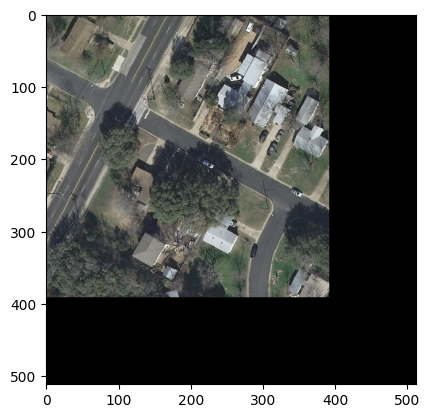

In [40]:
import h5py
from numpy import pad
from matplotlib import pyplot as plt

def get_padded_image(dataset: Any, idx: int, height_begin: int, height_end: int, width_begin: int, width_end: int) -> NDArray:
        dataset_max_height = dataset.shape[1]
        dataset_max_width = dataset.shape[2]
        image = pad(
            dataset[idx, height_begin: dataset_max_height, width_begin: dataset_max_width, :],
            ((0, height_end - dataset_max_height), (0, width_end - dataset_max_width), (0, 0)),
            "constant",
            constant_values = 0
        )
        return image

with h5py.File(DATA / "inria.h5") as f:
    image = get_padded_image(
        dataset = f["images"],
        idx = 0,
        height_begin = 4608,
        height_end = 5120,
        width_begin = 4608,
        width_end = 5120,
    )
    print(image.shape)
    plt.imshow(image)

In [32]:
def some_func(a, b):
    print(a, b)

some_func(**{"a": 10, "b": 5})

10 5
